# DeepASM

## Install packages

In [ ]:
# To manipulate HDF5 files (RUN FOR ALL MODELS)
!pip3 install --upgrade tables

## Import packages

In [1]:
import sys

# Python packages for data, stats, and visualization
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns 

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import load_model
from tensorflow.keras import layers
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Kernel functions
from sklearn.neighbors import KernelDensity
from numpy import asarray
from matplotlib import pyplot
from numpy import exp

# Dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA, NMF, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding

# To get the time
from datetime import datetime

# To write on the same line
from IPython.display import clear_output
 
# Figure parameters
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Print different versions
print(sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Numpy version:", np.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
TensorFlow version: 2.7.0
Keras version: 2.7.0
Numpy version: 1.19.5
Num GPUs Available:  1


## GCP Variables

In [4]:
# Import raw data from bucket. False if you want to import the processed dataset
IMPORT_RAW_FROM_BUCKET = True

# Export data after it's been prepared
EXPORT_PROCESSED_DATA = True

# Import data after its features have been prepared
IMPORT_PROCESSED_DATA = False
PROCESSED_DATA_PATH = "deepasm/notebook/500000_rows_2022-03-14_17-41-51"

# Bucket name where the training datasets are
DEEPASM_BUCKET="deepasm"


## Dataset used for training

In [5]:
# Run the training on a small sample size (50k)
TEST_RUN = True

# Size of the genomic window (250bp, 500bp, 1000bp)
GENOMIC_INTERVAL = 250

# Number of rows to take into the dataset after import
if TEST_RUN == True:
    NB_ROWS_RAW_DATASET = int(500000) # The maximum is 5e6. We use 200k to test the code
else:
    NB_ROWS_RAW_DATASET = int(5e6) 

## Model variables

In [6]:
# MODELS FOR WHICH WE NEED TO RECORD THE RESULTS

models = ['linear', 'perceptron', 'simple_cnn',  'cnn', 'simple_rnn', 'rnn']
#models = ['simple_rnn']

# Loss is better than AUC for monitoring
PARAM_TO_CHANGE = "keep_chr"

#--------------------------------------------------
# Parameters common to all models

# Minimum correlation factor. Under that, remove features
MIN_CORR = 0.05

# Kernel values for probability estimates
KERNEL_FM_NB_VALUES = 10
KERNEL_FM_BANDWIDTH = 0.1
KERNEL_COV_NB_MAX = 200
KERNEL_COV_NB_STEP = 40
KERNEL_COV_BANDWIDTH = 20

# Early stopping
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='auto',
    restore_best_weights=True)

# Percentage of data points to be used in the Test dataset
TEST_SPLIT = 0.2

# Percentage of datapoints used between training and validation
VALIDATION_SPLIT = 0.3 # How to divide the training dataset for validation

EPOCHS = 100 # We have so many datapoints that 20 epochs are enough to stabilize the training
BATCH_SIZE = 1000 # to get a few identified ASM we need at a few hundreds since the
# frequency of ASM is 1.38%
# A batch size of 1000 will run into a memory error on TF 2.7

# Regularlization L1 and L2 (defaults are l1 = 0.01 and l2 = 0.01)
L1_R = 0
L2_R = 1e-3

#--------------------------------------------------
# Parameters common to neural network models
ACTIVATION_FUNCTION = 'relu' # 'tanh' # or 'relu' or 'gelu (Gaussian Error Linear Unit)'
NB_NODES_PERCEPTRON = 10
NB_LAYERS_PERCEPTRON = 5
NB_NODES_AFTER_CNN = 2

# CNN parameters
CNN_FILTERS = 32
CNN_KERNEL = 750 # Must be smaller than the genomic region (250). The av distance between CpG is 37 bp and the std dev of the distances between cpgs is 24 bp
LEARNING_RATE = 3e-4 

# Learning rate was taken from this
# http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

#--------------------------------------------------
# Parameters common to RNN

RNN_UNITS = 128 # 64 orginally

#--------------------------------------------------
# SPECIFIC TO RANDOM FOREST ALGORITHM
use_raw_df_for_forest_models = False

## ML evaluation metrics

In [7]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='sensitivity'),
      keras.metrics.AUC(name='auc')
      ]

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'sensitivity']
  plt.figure(figsize=(10,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0,1])

    plt.legend()


def display_results(df_results):
  print("Loss", np.round(df_results[0], 3))
  print("True positives", np.round(df_results[1], 3))
  print("False positives", np.round(df_results[2], 3))
  print("True negatives", np.round(df_results[3], 3))
  print("False negatives", np.round(df_results[4], 3))
  print("Accuracy", np.round(df_results[5], 3))
  print("Precision", np.round(df_results[6], 3))
  print("Sensitivity", np.round(df_results[7], 3))
  print("AUC", np.round(df_results[8], 3))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,80])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')



2022-03-15 16:07:15.276668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 16:07:15.815357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38444 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


## Import raw data

In [7]:
if IMPORT_RAW_FROM_BUCKET == True:
    !gsutil ls gs://$DEEPASM_BUCKET/$GENOMIC_INTERVAL*bp/encode_training_data/*.json > list_to_download.txt
    files_to_download_df = pd.read_csv('list_to_download.txt', header=None)
    print("Number of files to download:", files_to_download_df.shape[0])

    imported_df = pd.DataFrame()
    
    if TEST_RUN == True:
        range_files = 1
    else: # Download all the files
        range_files = files_to_download_df.shape[0]

    for index_file in range(range_files): 
        file_name_bucket = files_to_download_df[0][index_file]
        local_file_name = "training_" + str(index_file) + ".json"
        
        # Download the file from bucket
        !gsutil cp $file_name_bucket $local_file_name
        
        print("Appending file...")
        imported_df = imported_df.append(pd.read_json(local_file_name, lines = True))

Number of files to download: 8
Copying gs://deepasm/250bp/encode_training_data/encode_training-000000000000.json...
- [1 files][300.1 MiB/300.1 MiB]                                                
Operation completed over 1 objects/300.1 MiB.                                    
Appending file...


In [8]:
print("Size of the imported dataset:", imported_df.shape)

Size of the imported dataset: (489888, 18)


## Prepare the features

Note: we do not randomize the rows because the scripts preceding this notebook already sampled the rows.

### Copy & clean dataframe 

In [9]:
# Copy of the dataframe
raw_df = imported_df.copy()
raw_df = raw_df.head(NB_ROWS_RAW_DATASET)

# Randomize the rows
raw_df = raw_df.sample(frac = 1, ignore_index = True)


In [10]:
print("Size of the dataset: ", raw_df.shape)
print("Number of samples (12 expected):", len(raw_df['sample'].unique()))
print("Chromosomes found (24 expected):", raw_df['chr'].unique())

# We remove the sample column
raw_df = raw_df.drop('sample', axis = 1)

# We remove chromosomes X and Y because ASM cannot be reliabily evaluated in these chromosomes
raw_df = raw_df[raw_df['chr'] != 'X']
raw_df = raw_df[raw_df['chr'] != 'Y']

# We remove the chr column
raw_df = raw_df.drop('chr', axis = 1)

Size of the dataset:  (489888, 18)
Number of samples (12 expected): 12
Chromosomes found (24 expected): ['14' '9' '1' '18' '16' '8' '13' '15' '3' '21' '5' '17' '11' '10' '20'
 '19' '2' '12' '6' '7' '4' 'X' '22' 'Y']


In [11]:
raw_df

,asm_snp,sample_category,region_inf,region_sup,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,read_fm,cpg_fm,cpg_pos
0,0,1,43110501,43110750,3,3,83,0,0,0,0.569,17958798,252140560,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.333, 1, 0, 1,...","[0.333, 0.016, 0.035]","[43110572, 43110636, 43110666]"
1,0,0,90275001,90275250,13,12,90,0,0,6,0.783,17105603,218296326,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.833, 1, 1,...","[0.982, 0.962, 1, 1, 1, 1, 1, 0.926, 0.964, 0....","[90275010, 90275039, 90275049, 90275069, 90275..."
2,0,1,23820501,23820750,8,8,52,0,0,1,0.683,18381838,283211149,"[0.333, 1, 1, 0.5, 1, 0.667, 0.667, 1, 1, 1, 0...","[0.30000000000000004, 0.963, 0.931, 0.929, 0.9...","[23820528, 23820540, 23820564, 23820588, 23820..."
3,0,1,13404001,13404250,9,9,65,1,0,7,0.569,17958798,252140560,"[0.429, 0.5, 0.667, 0.167, 0.5, 0.333, 0, 1, 0...","[0.808, 0.321, 0.5, 0.778, 0.444, 0.125, 0.4, ...","[13404001, 13404016, 13404067, 13404133, 13404..."
4,0,0,81505501,81505750,5,5,53,1,0,0,0.752,15554984,129787112,"[1, 1, 0.667, 1, 0.75, 1, 1, 1, 1, 1, 1, 1, 1,...","[0.9570000000000001, 0.9580000000000001, 0.968...","[81505557, 81505638, 81505674, 81505692, 81505..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489883,0,1,8851001,8851250,8,7,70,0,0,0,0.569,17958798,252140560,"[1, 1, 1, 1, 1, 1, 0.75, 0.8, 1, 1, 1, 1, 1, 1...","[0.972, 0.973, 0.914, 0.972, 1, 0.885, 1]","[8851026, 8851044, 8851088, 8851132, 8851176, ..."
489884,0,1,74395251,74395500,9,8,127,0,0,0,0.652,17435901,332640300,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1, 0.667, 1, ...","[0.904, 0.963, 0.873, 0.9450000000000001, 1, 0...","[74395266, 74395276, 74395353, 74395397, 74395..."
489885,0,1,131418751,131419000,5,4,70,0,0,0,0.689,15819966,244695432,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 0.971, 1]","[131418788, 131418790, 131418813, 131418948]"
489886,0,0,88542751,88543000,3,3,91,0,0,0,0.759,17010222,205958742,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0.667, 1, 1, 1, 1,...","[0.963, 0.986, 0.803]","[88542779, 88542785, 88542811]"


### Calculate the distance between CpGs

In [12]:
# Create a function to calculate the distance between CpGs (~3min)
def dist_cpg(cpg_pos):
  distances = []
  for index in range(len(cpg_pos)):
    if index >= len(cpg_pos)-1:
      return distances
    else:
      distances.append(cpg_pos[index + 1] - cpg_pos[index])
  return distances

# Apply the function "distance" to the array of CpG positions
raw_df['cpg_dist'] = raw_df['cpg_pos'].apply(lambda x: dist_cpg(x))

### Convert arrays into numerical features

To do this, we use kernel estimates as well as simpler metrics like mean and standard deviation

#### Kernel functions

In [13]:
# FRACTIONAL METHYLATION

# Values for fractional methylation (between 0 and 1)
values_for_kernel_fm = asarray([value for value in range(0, KERNEL_FM_NB_VALUES+1)])
values_for_kernel_fm = values_for_kernel_fm / KERNEL_FM_NB_VALUES
print("X-axis values used for the FM kernel estimate:", values_for_kernel_fm)
values_for_kernel_fm = values_for_kernel_fm.reshape((len(values_for_kernel_fm), 1))

# Build Kernel model
kernel_fm_model = KernelDensity(bandwidth=KERNEL_FM_BANDWIDTH, kernel='gaussian')

# Function to be applied to each array in the columns read_fm and cpg_fm
def estimate_kernels_fm(x):
  sample = np.reshape(x, (len(x), 1))
  kernel_fm_model.fit(sample)
  probabilities = kernel_fm_model.score_samples(values_for_kernel_fm)
  probabilities = exp(probabilities)
  return np.round(probabilities, 4)

# Try function
#estimate_kernels_fm(raw_df['cpg_fm'][0])


X-axis values used for the FM kernel estimate: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [14]:
# COVERAGE AND CPG DISTANCE

# Values for fractional methylation (between 0 and 1)
values_for_kernel_cov = asarray([value for value in range(0, KERNEL_COV_NB_MAX, KERNEL_COV_NB_STEP)])
print("Values used in kernel estimate:", values_for_kernel_cov)
values_for_kernel_cov = values_for_kernel_cov.reshape((len(values_for_kernel_cov), 1))

# Build Kernel model
kernel_cov_model = KernelDensity(bandwidth=KERNEL_COV_BANDWIDTH, kernel='gaussian')

# Function to be applied to each array in the columns read_fm and cpg_fm
def estimate_kernels_cov(x):
  sample = np.reshape(x, (len(x), 1))
  kernel_fm_model.fit(sample)
  probabilities = kernel_fm_model.score_samples(values_for_kernel_cov)
  probabilities = exp(probabilities)
  return np.round(probabilities, 4)

# Try function
#estimate_kernels_cov(raw_df['cpg_cov'][1])

Values used in kernel estimate: [  0  40  80 120 160]


#### Test kernel estimates

In [15]:
variable_to_plot = 'cpg_fm' # cpg_fm or read_fm or cpg_dist or cpg_cov

n_extract = 10
extract_asm = raw_df[raw_df['asm_snp'] == 1].sample(n=n_extract, ignore_index = True)
extract_noasm = raw_df[raw_df['asm_snp'] == 0].sample(n=n_extract, ignore_index = True)
n_x = round(np.sqrt(n_extract))

##### Plots for regions with ASM

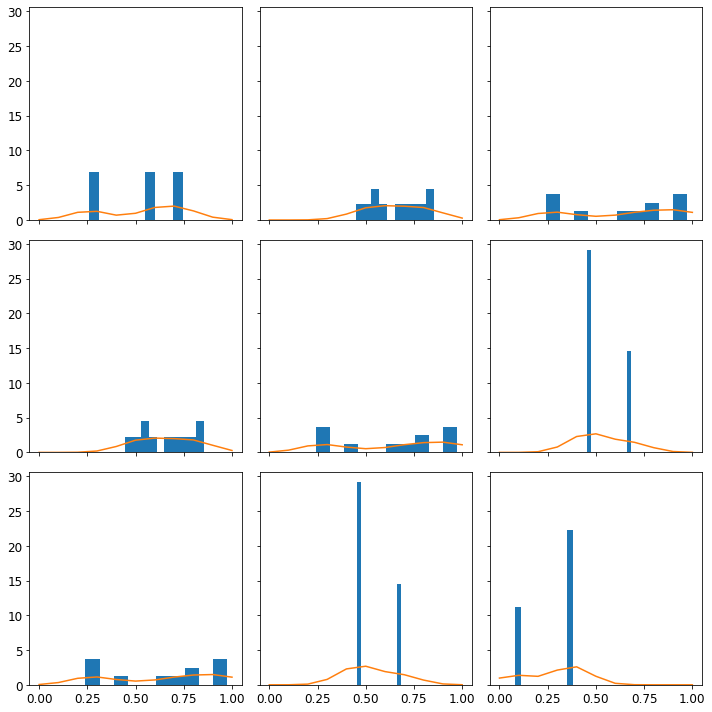

In [16]:
mpl.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(n_x, n_x, sharey=True, sharex=True, tight_layout=True)

for k in range(n_x):
  for m in range(n_x):

    # Print data distribution
    data_distribution = extract_asm[variable_to_plot][k+m]
    axs[k,m].hist(data_distribution, density = True, bins = 10)

    # Print kernel density
    if 'fm' in variable_to_plot:
        #print("Using the FM kernel estimates")
        kernel_probabilities = estimate_kernels_fm(data_distribution)
        values = values_for_kernel_fm
    else:
        #print("Using the COV kernel estimates")
        kernel_probabilities = estimate_kernels_cov(data_distribution)
        values = values_for_kernel_cov
    axs[k,m].plot(values[:], kernel_probabilities)


##### Plots for regions without ASM

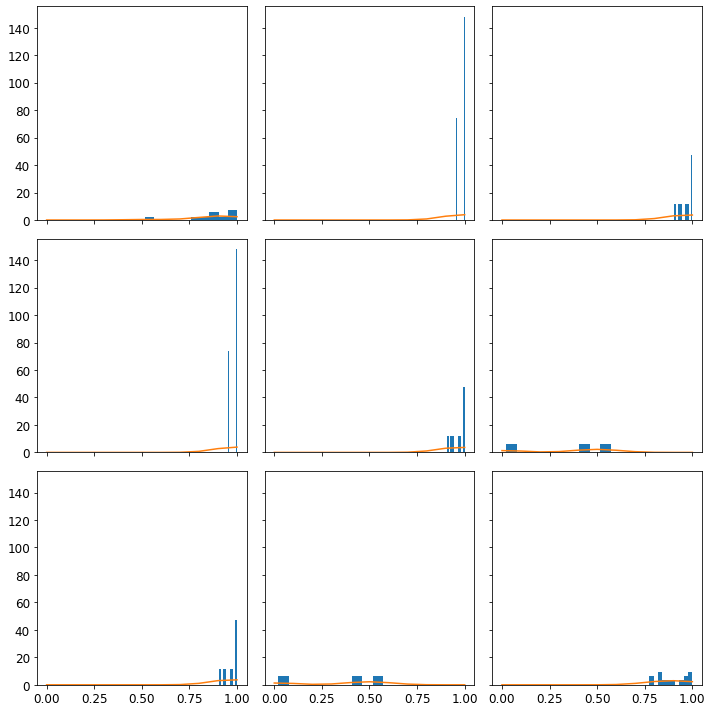

In [17]:
mpl.rcParams['figure.figsize'] = (10, 10)
fig, axs = plt.subplots(n_x, n_x, sharey=True, sharex=True, tight_layout=True)

for k in range(n_x):
  for m in range(n_x):

    # Print data distribution
    data_distribution = extract_noasm[variable_to_plot][k+m]
    axs[k,m].hist(data_distribution, density = True, bins = 10)

    # Print kernel density
    if 'fm' in variable_to_plot:
        #print("Using the FM kernel estimates")
        kernel_probabilities = estimate_kernels_fm(data_distribution)
        values = values_for_kernel_fm
    else:
        #print("Using the COV kernel estimates")
        kernel_probabilities = estimate_kernels_cov(data_distribution)
        values = values_for_kernel_cov
    axs[k,m].plot(values[:], kernel_probabilities)

#### Calculate the mean, std, and kernel estimates of arrays

In [18]:
def convert_arrays(df, column_name):
  """Inputs: dataframe and a column name that contains arrays"""

  # Mean and Standard deviation
  std_name = "std_" + column_name
  av_name = "mean_" + column_name

  print("Calculating the standard deviation")
  df[std_name] = df[column_name].apply(lambda x: np.round(np.std(x), 4))
  print("Calculating the average")
  df[av_name] = df[column_name].apply(lambda x: np.round(np.mean(x), 4))
  
  # Kernel density estimates
  kernel_name = "kernel_" + column_name
  if (column_name == 'cpg_cov' or column_name == 'cpg_dist'):
    print("Calculating the proba distribution for cov or dist")
    df[kernel_name] = df[column_name].apply(lambda x: estimate_kernels_cov(x))
  else:
    print("Calculating the proba distribution for fractional methylation")
    df[kernel_name] = df[column_name].apply(lambda x: estimate_kernels_fm(x))


In [19]:
# Apply the function
for col in ['read_fm', 'cpg_fm', 'cpg_dist']:
    clear_output(wait=True)
    print("Column: ", col)
    convert_arrays(raw_df, col)
print("DONE")

Column:  cpg_dist
Calculating the standard deviation
Calculating the average
Calculating the proba distribution for cov or dist
DONE


In [20]:
def export_kernel_array(col):
    # Col must be a column of kernel estimate arrays
    print("Processing:", col)
    kernel_name_list = []
    if 'fm' in col:
        values = values_for_kernel_fm
    else:
        values = values_for_kernel_cov
    # Create a list of the new column names
    for k in range(0, values.shape[0]):
        kernel_name = col + "_kernel_" + str(k)
        kernel_name_list = kernel_name_list + [kernel_name]
    print(kernel_name_list)
    
    # Create the additional columns
    kernel_estimates_column = "kernel_" + col
    raw_df[kernel_name_list] = pd.DataFrame(raw_df[kernel_estimates_column].tolist(), index= raw_df.index)

In [21]:
# Use the function
for col in ['read_fm', 'cpg_fm', 'cpg_dist']:
    export_kernel_array(col)

Processing: read_fm
['read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2', 'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5', 'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8', 'read_fm_kernel_9', 'read_fm_kernel_10']
Processing: cpg_fm
['cpg_fm_kernel_0', 'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9', 'cpg_fm_kernel_10']
Processing: cpg_dist
['cpg_dist_kernel_0', 'cpg_dist_kernel_1', 'cpg_dist_kernel_2', 'cpg_dist_kernel_3', 'cpg_dist_kernel_4']


In [22]:
# Delete columns that we no longer need
for col in ['read_fm', 'cpg_dist',
            'kernel_cpg_dist', 'kernel_cpg_fm', 'kernel_read_fm']:
    raw_df.drop(col, axis = 1, inplace = True)

### Convert epigenetic signals into dummy variables

#### Plot histograms for the values of epigenetic signals

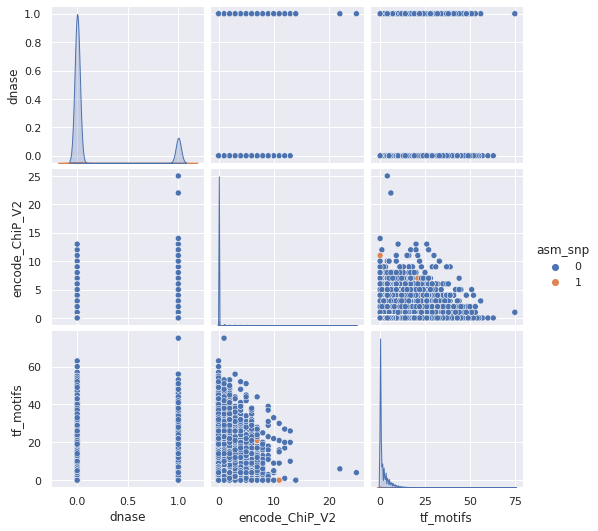

In [23]:
#df_extract = raw_df[['dnase','encode_ChiP_V2', 'tf_motifs']]
#df_extract
#hist = raw_df[['dnase','encode_ChiP_V2', 'tf_motifs']].hist(density = True, bins = 3)

sns.set(rc = {'figure.figsize':(12,12)})
sns.pairplot(raw_df[['asm_snp','dnase','encode_ChiP_V2', 'tf_motifs']], hue = 'asm_snp', diag_kind='kde')

In [24]:
raw_df.columns

Index(['asm_snp', 'sample_category', 'region_inf', 'region_sup',
       'region_nb_cpg', 'nb_cpg_found', 'nb_reads', 'dnase', 'encode_ChiP_V2',
       'tf_motifs', 'global_cpg_fm', 'tot_nb_cpg', 'tot_nb_reads', 'cpg_fm',
       'cpg_pos', 'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'mean_cpg_fm',
       'std_cpg_dist', 'mean_cpg_dist', 'read_fm_kernel_0', 'read_fm_kernel_1',
       'read_fm_kernel_2', 'read_fm_kernel_3', 'read_fm_kernel_4',
       'read_fm_kernel_5', 'read_fm_kernel_6', 'read_fm_kernel_7',
       'read_fm_kernel_8', 'read_fm_kernel_9', 'read_fm_kernel_10',
       'cpg_fm_kernel_0', 'cpg_fm_kernel_1', 'cpg_fm_kernel_2',
       'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5',
       'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8',
       'cpg_fm_kernel_9', 'cpg_fm_kernel_10', 'cpg_dist_kernel_0',
       'cpg_dist_kernel_1', 'cpg_dist_kernel_2', 'cpg_dist_kernel_3',
       'cpg_dist_kernel_4'],
      dtype='object')

In [25]:
def convert_epi_signal(epi_signal):
  print("Processing signal", epi_signal)
  unique_values = raw_df[epi_signal].unique()
  print(unique_values)
  min_epi_value = 0 # It's always zero (no signal) for all signals
  median_epi_value = np.median(unique_values)
  print("Median epi value:", median_epi_value)
  epi_signal_null = epi_signal + "_null"
  epi_signal_low = epi_signal + "_low"
  epi_signal_high = epi_signal + "_high"
  raw_df[epi_signal_null] = raw_df[epi_signal].apply(lambda x: 1 if x == min_epi_value else 0)
  raw_df[epi_signal_low] = raw_df[epi_signal].apply(lambda x: 1 if (x > min_epi_value and x <= median_epi_value) else 0)
  raw_df[epi_signal_high] = raw_df[epi_signal].apply(lambda x: 1 if x > median_epi_value else 0)

In [26]:
# Apply the function to all epigenetic signals
for epi_signal in ['dnase', 'encode_ChiP_V2', 'tf_motifs']:
  convert_epi_signal(epi_signal)

Processing signal dnase
[0 1]
Median epi value: 0.5
Processing signal encode_ChiP_V2
[ 0  2  1  3 11  7  4  5  6  9 12 10  8 25 14 13 22]
Median epi value: 8.0
Processing signal tf_motifs
[ 0  6  1  7  3  5  9 11  2  4 13 12 15  8 33 21 19 28 35 16 10 24 17 14
 22 23 30 25 20 26 48 18 32 39 41 29 34 27 31 38 44 46 47 40 37 45 36 57
 51 55 53 42 43 56 50 52 54 75 49 63 60]
Median epi value: 30.0


In [27]:
# Delete the raw epigenetic signals
# for epi_signal in ['dnase', 'encode_ChiP_V2', 'tf_motifs']:
#   raw_df.drop(epi_signal, axis = 1, inplace = True)

In [28]:
raw_df.columns

Index(['asm_snp', 'sample_category', 'region_inf', 'region_sup',
       'region_nb_cpg', 'nb_cpg_found', 'nb_reads', 'dnase', 'encode_ChiP_V2',
       'tf_motifs', 'global_cpg_fm', 'tot_nb_cpg', 'tot_nb_reads', 'cpg_fm',
       'cpg_pos', 'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'mean_cpg_fm',
       'std_cpg_dist', 'mean_cpg_dist', 'read_fm_kernel_0', 'read_fm_kernel_1',
       'read_fm_kernel_2', 'read_fm_kernel_3', 'read_fm_kernel_4',
       'read_fm_kernel_5', 'read_fm_kernel_6', 'read_fm_kernel_7',
       'read_fm_kernel_8', 'read_fm_kernel_9', 'read_fm_kernel_10',
       'cpg_fm_kernel_0', 'cpg_fm_kernel_1', 'cpg_fm_kernel_2',
       'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5',
       'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8',
       'cpg_fm_kernel_9', 'cpg_fm_kernel_10', 'cpg_dist_kernel_0',
       'cpg_dist_kernel_1', 'cpg_dist_kernel_2', 'cpg_dist_kernel_3',
       'cpg_dist_kernel_4', 'dnase_null', 'dnase_low', 'dnase_high',
       'encode_ChiP_V

## Create an "image" of the genomic region

We create an 1D-image (length: genomic region interval) with 3 information per "pixel": CpG presence (0 or 1), CpG coverage, CpG fractional methylation

In [29]:
# Create arrays of positions, fractional methylation, and coverage for CpGs (~2h30)
def create_genomic_array(df):
    genomic_positions = []
    genomic_fm = []
    for position in range(df['region_inf'], df['region_sup'] + 1):
        if position in df['cpg_pos']:
            new_pos = 1
            pos_index = df['cpg_pos'].index(position)
            new_fm = df['cpg_fm'][pos_index]
        else:
            new_pos = 0
            new_fm = 0
        genomic_positions = genomic_positions + [new_pos]
        genomic_fm = genomic_fm + [new_fm]
    return np.transpose([genomic_positions, genomic_fm])


In [30]:
# Test function
d = {'cpg_pos': [[2],[21,22]], 
              'region_inf':[1,20], 
              'region_sup':[4,23],
              'cpg_fm': [[0.0],[1.0,0.0]]
             }
example_df = pd.DataFrame(data = d)
example_df['genomic_pic'] = example_df.apply(lambda x: create_genomic_array(x), axis = 1)
example_df

,cpg_pos,region_inf,region_sup,cpg_fm,genomic_pic
0,[2],1,4,[0.0],"[[0.0, 0.0], [1.0, 0.0], [0.0, 0.0], [0.0, 0.0]]"
1,"[21, 22]",20,23,"[1.0, 0.0]","[[0.0, 0.0], [1.0, 1.0], [1.0, 0.0], [0.0, 0.0]]"


### Split the dataset for calculating the images

In [31]:
# Split the dataframe into a list of dataframes of 10 rows. Otherwise it stalls
nb_dataframe_pieces = max(1, round(raw_df.shape[0]/50))
raw_df_pieces = np.array_split(raw_df, nb_dataframe_pieces)
print("The dataframe has been split into", nb_dataframe_pieces, "pieces")


The dataframe has been split into 9662 pieces


In [32]:
# Apply the function to the dataframe which we split before because it takes a lot of memory.
for df_piece in range(nb_dataframe_pieces): # nb_dataframe_pieces
        clear_output(wait=True)
        print("processing the piece at position:", df_piece)
        raw_df_pieces[df_piece]['genomic_matrix'] = raw_df_pieces[df_piece].apply(lambda x: create_genomic_array(x), 
                                                                                      axis = 1)

processing the piece at position: 9661


In [33]:
# Concatenate the dataframes
prepared_df = pd.DataFrame()

for df_piece in range(nb_dataframe_pieces):
    clear_output(wait=True)
    print("processing the piece at position:", df_piece)
    tmp_df = raw_df_pieces[df_piece]
    for var in ['cpg_pos', 'cpg_fm', 'region_inf', 'region_sup']:
        tmp_df.drop(var, axis = 1, inplace = True)
    prepared_df = prepared_df.append(tmp_df)

processing the piece at position: 9661


## Save dataframe with features on Cloud Storage

In [34]:
# Check the columns
prepared_df.columns

Index(['asm_snp', 'sample_category', 'region_nb_cpg', 'nb_cpg_found',
       'nb_reads', 'dnase', 'encode_ChiP_V2', 'tf_motifs', 'global_cpg_fm',
       'tot_nb_cpg', 'tot_nb_reads', 'std_read_fm', 'mean_read_fm',
       'std_cpg_fm', 'mean_cpg_fm', 'std_cpg_dist', 'mean_cpg_dist',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8',
       'read_fm_kernel_9', 'read_fm_kernel_10', 'cpg_fm_kernel_0',
       'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3',
       'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6',
       'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9',
       'cpg_fm_kernel_10', 'cpg_dist_kernel_0', 'cpg_dist_kernel_1',
       'cpg_dist_kernel_2', 'cpg_dist_kernel_3', 'cpg_dist_kernel_4',
       'dnase_null', 'dnase_low', 'dnase_high', 'encode_ChiP_V2_null',
       'encode_ChiP_V2_low', 'encode_ChiP_V2_hi

In [35]:
# Obtain the date/time
now = datetime.today()
dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
print(dt_string)

2022-03-15_16-04-20


In [36]:
# Export the variable names to the bucket
sys.stdout = open("variables.txt", "w")
%whos

In [37]:
# Export variable names to to Cloud Storage
dt_string = str(GENOMIC_INTERVAL) + "bp_" + str(NB_ROWS_RAW_DATASET) + "rows_" + dt_string
!gsutil cp variables.txt gs://$DEEPASM_BUCKET/notebook/$dt_string/

In [38]:
if EXPORT_PROCESSED_DATA == True:
    
    nb_pieces_export = max(1, round(raw_df.shape[0]/10000))
    prepared_df_pieces = np.array_split(prepared_df, nb_pieces_export)
    print("The dataframe has been split into", nb_pieces_export, "pieces")
    
    for df_piece in range(nb_pieces_export):
        print("processing the piece at position:", df_piece)
        df_to_export = prepared_df_pieces[df_piece]
        print("Size of dataframe:", df_to_export.shape)

        print("Saving the file as HDF5...")
        file_name = "prepared_df_" + str(df_piece) + ".h5"
        print("File name:", file_name)
        df_to_export.to_hdf(file_name, key = 'df', mode = 'w')

        print("Exporting file to bucket...")
        !gsutil cp $file_name gs://$DEEPASM_BUCKET/notebook/$dt_string/
else:
        print("Not exporting the scaled DF per variable")

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['genomic_matrix'], dtype='object')]

  encoding=encoding,


## Importing prepared features from bucket

In [8]:
if IMPORT_PROCESSED_DATA == True:
    display("Downloading from the bucket...")
    # Obtain path from GCP Cloud Storage
    bucket_path = "gs://" + PROCESSED_DATA_PATH
    file_path = bucket_path + "/*.h5"

    # Find all the H5 files with the same normalization method.
    !gsutil ls $file_path > list_to_download.txt
    files_to_download_df = pd.read_csv('list_to_download.txt', header=None)

    prepared_df = pd.DataFrame()

    for index_file in range(files_to_download_df.shape[0]):
        clear_output(wait=True)
        display("Processing file:", index_file)
        file_name_bucket = bucket_path + "/prepared_df_" + str(index_file) + ".h5"
        display(file_name_bucket)
        file_name_local = "prepared_df_" +  str(index_file) + ".h5"
        !gsutil cp $file_name_bucket $file_name_local
        tmp = pd.read_hdf(file_name_local)
        prepared_df = prepared_df.append(tmp)
else:
    display("Not downloading from the bucket")
    prepared_df = pd.DataFrame()
    !ls *.h5 > list_files.txt
    files_to_append = pd.read_csv('list_files.txt', header=None)
    for file_number in range(files_to_append.shape[0]):
        clear_output(wait=True)
        file_name_local = "prepared_df_" +  str(file_number) + ".h5"
        print("Processing:", file_name_local)
        tmp = pd.read_hdf(file_name_local)
        prepared_df = prepared_df.append(tmp)

Processing: prepared_df_47.h5


In [9]:
print("Dataset size:", prepared_df.shape)
print("Columns of dataset:", prepared_df.columns)

Dataset size: (483092, 54)
Columns of dataset: Index(['asm_snp', 'sample_category', 'region_nb_cpg', 'nb_cpg_found',
       'nb_reads', 'dnase', 'encode_ChiP_V2', 'tf_motifs', 'global_cpg_fm',
       'tot_nb_cpg', 'tot_nb_reads', 'std_read_fm', 'mean_read_fm',
       'std_cpg_fm', 'mean_cpg_fm', 'std_cpg_dist', 'mean_cpg_dist',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8',
       'read_fm_kernel_9', 'read_fm_kernel_10', 'cpg_fm_kernel_0',
       'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3',
       'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6',
       'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9',
       'cpg_fm_kernel_10', 'cpg_dist_kernel_0', 'cpg_dist_kernel_1',
       'cpg_dist_kernel_2', 'cpg_dist_kernel_3', 'cpg_dist_kernel_4',
       'dnase_null', 'dnase_low', 'dnase_high', 'encode_ChiP_V2_null',


In [40]:
prepared_df.describe()

,asm_snp,sample_category,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,...,cpg_dist_kernel_4,dnase_null,dnase_low,dnase_high,encode_ChiP_V2_null,encode_ChiP_V2_low,encode_ChiP_V2_high,tf_motifs_null,tf_motifs_low,tf_motifs_high
count,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,4.830920e+05,...,483092.000000,483092.000000,483092.0,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000,483092.000000
mean,0.013881,0.556109,6.524794,6.104537,83.400067,0.144623,0.046217,1.809096,0.704216,1.686030e+07,...,0.001422,0.855377,0.0,0.144623,0.973347,0.026548,0.000106,0.571856,0.427132,0.001012
std,0.116999,0.496842,4.175172,3.971923,41.800399,0.351720,0.357028,3.483582,0.084342,1.527641e+06,...,0.047039,0.351720,0.0,0.351720,0.161068,0.160758,0.010274,0.494810,0.494662,0.031799
min,0.000000,0.000000,3.000000,3.000000,10.000000,0.000000,0.000000,0.000000,0.564000,1.054282e+07,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000,4.000000,54.000000,0.000000,0.000000,0.000000,0.652000,1.581997e+07,...,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,5.000000,5.000000,75.000000,0.000000,0.000000,0.000000,0.689000,1.729172e+07,...,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,8.000000,7.000000,104.000000,0.000000,0.000000,2.000000,0.783000,1.795880e+07,...,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,59.000000,59.000000,487.000000,1.000000,25.000000,75.000000,0.824000,1.838184e+07,...,1.994700,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Class weights

There are approximately 100x more regions without ASM than with ASM. We'll have to use weights in our training.

In [24]:
neg, pos = np.bincount(prepared_df['asm_snp'])
total = neg + pos
print('Number of regions assessed for ASM: {}\nRegions with ASM found: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Number of regions assessed for ASM: 483092
Regions with ASM found: 6706 (1.39% of total)



In [25]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight_asm = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 36.02


## Normalize the features

In [50]:
prepared_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            489877, 489878, 489879, 489881, 489882, 489883, 489884, 489885,
            489886, 489887],
           dtype='int64', length=483092)

In [37]:
non_continous_columns = ['asm_snp', 'sample_category', 'dnase', 
                                    'dnase_high', 'dnase_null', 'dnase_low', 
                                    'encode_ChiP_V2_low', 'encode_ChiP_V2_null', 'encode_ChiP_V2_high',
                                    'tf_motifs_null', 'tf_motifs_low', 'tf_motifs_null',
                                    'genomic_matrix']

In [53]:
prepared_df.tail()

,asm_snp,sample_category,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,...,dnase_null,dnase_low,dnase_high,encode_ChiP_V2_null,encode_ChiP_V2_low,encode_ChiP_V2_high,tf_motifs_null,tf_motifs_low,tf_motifs_high,genomic_matrix
489883,0,1,8,7,70,0,0,0,0.569,17958798,...,1,0,0,1,0,0,1,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489884,0,1,9,8,127,0,0,0,0.652,17435901,...,1,0,0,1,0,0,1,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489885,0,1,5,4,70,0,0,0,0.689,15819966,...,1,0,0,1,0,0,1,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489886,0,0,3,3,91,0,0,0,0.759,17010222,...,1,0,0,1,0,0,1,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489887,0,0,7,6,131,1,0,0,0.809,18257641,...,0,0,1,1,0,0,1,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."


,region_nb_cpg,nb_cpg_found,nb_reads,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,std_read_fm,mean_read_fm,...,cpg_fm_kernel_7,cpg_fm_kernel_8,cpg_fm_kernel_9,cpg_fm_kernel_10,cpg_dist_kernel_0,cpg_dist_kernel_1,cpg_dist_kernel_2,cpg_dist_kernel_3,cpg_dist_kernel_4,tf_motifs_high
489883,8,7,70,0,0,0.569,17958798,252140560,0.0848,0.9688,...,0.2153,1.2363,3.1354,3.4733,0.0,0.0,0.0,0.0,0.0,0
489884,9,8,127,0,0,0.652,17435901,332640300,0.1367,0.9499,...,0.2625,1.4157,3.3287,3.3451,0.0,0.0,0.0,0.0,0.0,0
489885,5,4,70,0,0,0.689,15819966,244695432,0.0395,0.9952,...,0.0586,0.6361,2.5899,3.9484,0.0,0.0,0.0,0.0,0.0,0
489886,3,3,91,0,0,0.759,17010222,205958742,0.1997,0.9195,...,0.8465,1.9173,2.8399,2.7497,0.0,0.0,0.0,0.0,0.0,0
489887,7,6,131,0,0,0.809,18257641,248603116,0.2086,0.9391,...,0.2049,1.2343,3.1895,3.4921,0.0,0.0,0.0,0.0,0.0,0


In [68]:
# Copy dataframe and remove non-continous variables
normalized_df = prepared_df.copy()
normalized_df = normalized_df.drop(columns = non_continous_columns)

# Apply StandardScaler to continous variables
columns = normalized_df.columns
scaler = StandardScaler()
scaler.fit(normalized_df)
normalized_df = pd.DataFrame(data = scaler.transform(normalized_df), index = normalized_df.index)
normalized_df.columns = columns

# Concatenate with other columns
normalized_df = pd.concat([normalized_df, 
                           prepared_df[non_continous_columns], axis = 1)

normalized_df

,region_nb_cpg,nb_cpg_found,nb_reads,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,std_read_fm,mean_read_fm,...,cpg_fm_kernel_7,cpg_fm_kernel_8,cpg_fm_kernel_9,cpg_fm_kernel_10,cpg_dist_kernel_0,cpg_dist_kernel_1,cpg_dist_kernel_2,cpg_dist_kernel_3,cpg_dist_kernel_4,tf_motifs_high
0,3,3,83,0,0,0.569,17958798,252140560,0.2896,0.1566,...,0.0016,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0
1,13,12,90,0,6,0.783,17105603,218296326,0.0749,0.9781,...,0.1576,0.9989,2.9088,3.6582,0.0,0.0,0.0,0.0,0.0,0
2,8,8,52,0,1,0.683,18381838,283211149,0.2523,0.7570,...,0.1331,0.9526,2.5838,2.6466,0.0,0.0,0.0,0.0,0.0,0
3,9,9,65,0,7,0.569,17958798,252140560,0.3244,0.5110,...,0.8084,0.8959,0.5017,0.1079,0.0,0.0,0.0,0.0,0.0,0
4,5,5,53,0,0,0.752,15554984,129787112,0.0771,0.9815,...,0.1086,0.9460,3.0854,3.7811,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489883,8,7,70,0,0,0.569,17958798,252140560,0.0848,0.9688,...,0.2153,1.2363,3.1354,3.4733,0.0,0.0,0.0,0.0,0.0,0
489884,9,8,127,0,0,0.652,17435901,332640300,0.1367,0.9499,...,0.2625,1.4157,3.3287,3.3451,0.0,0.0,0.0,0.0,0.0,0
489885,5,4,70,0,0,0.689,15819966,244695432,0.0395,0.9952,...,0.0586,0.6361,2.5899,3.9484,0.0,0.0,0.0,0.0,0.0,0
489886,3,3,91,0,0,0.759,17010222,205958742,0.1997,0.9195,...,0.8465,1.9173,2.8399,2.7497,0.0,0.0,0.0,0.0,0.0,0


,region_nb_cpg,nb_cpg_found,nb_reads,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,std_read_fm,mean_read_fm,...,cpg_dist_kernel_0,cpg_dist_kernel_1,cpg_dist_kernel_2,cpg_dist_kernel_3,cpg_dist_kernel_4,tf_motifs_high,asm_snp,sample_category,dnase,genomic_matrix
0,-0.844228,-0.781621,-0.009571,-0.129449,-0.519321,-1.603182,0.719085,0.370250,0.538110,-1.895438,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
1,1.550885,1.484286,0.157892,-0.129449,1.203046,0.934097,0.160580,-0.251736,-1.375386,0.880083,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
2,0.353328,0.477216,-0.751191,-0.129449,-0.232260,-0.251547,0.996009,0.941261,0.205677,0.133074,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
3,0.592840,0.728983,-0.440189,-0.129449,1.490107,-1.603182,0.719085,0.370250,0.848262,-0.698062,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,1,"[[1.0, 0.808], [0.0, 0.0], [0.0, 0.0], [0.0, 0..."
4,-0.365206,-0.278086,-0.727268,-0.129449,-0.519321,0.566547,-0.854463,-1.878348,-1.355779,0.891570,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,0,1,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489883,0.353328,0.225448,-0.320573,-0.129449,-0.519321,-1.603182,0.719085,0.370250,-1.287153,0.848662,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489884,0.592840,0.477216,1.043052,-0.129449,-0.519321,-0.619097,0.376794,1.849665,-0.824598,0.784807,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489885,-0.365206,-0.529854,-0.320573,-0.129449,-0.519321,-0.180409,-0.681004,0.233424,-1.690885,0.937857,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,1,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
489886,-0.844228,-0.781621,0.181815,-0.129449,-0.519321,0.649543,0.098143,-0.478474,-0.263116,0.682097,...,0.0,-0.199081,-0.09661,-0.057059,-0.030232,-0.031832,0,0,0,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."


## Select the features to be used in the models

In [42]:
corr_matrix = pd.DataFrame(abs(normalized_df.corr()))
corr_matrix

,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,tot_nb_reads,std_read_fm,...,cpg_dist_kernel_4,dnase_null,dnase_low,dnase_high,encode_ChiP_V2_null,encode_ChiP_V2_low,encode_ChiP_V2_high,tf_motifs_null,tf_motifs_low,tf_motifs_high
region_nb_cpg,1.000000,0.954776,0.123216,0.362922,0.381270,0.350190,0.115485,0.022851,0.103014,0.255911,...,0.034869,0.206539,0.077608,0.296217,0.234769,0.216685,0.175878,0.040897,0.016357,0.216082
nb_cpg_found,0.954776,1.000000,0.189565,0.356995,0.370101,0.337627,0.113589,0.006009,0.092370,0.258057,...,0.034486,0.205976,0.081084,0.286684,0.229623,0.211884,0.172507,0.044691,0.021539,0.203661
nb_reads,0.123216,0.189565,1.000000,0.055962,0.050047,0.051647,0.217843,0.242989,0.384175,0.031622,...,0.013215,0.028661,0.008822,0.045711,0.038321,0.036255,0.020444,0.013227,0.011001,0.019303
dnase,0.362922,0.356995,0.055962,1.000000,0.311444,0.461753,0.079913,0.008760,0.074146,0.030374,...,0.012343,0.765826,0.523350,0.541081,0.417455,0.410974,0.073206,0.234420,0.223925,0.085597
encode_ChiP_V2,0.381270,0.370101,0.050047,0.311444,1.000000,0.334853,0.037215,0.001656,0.037661,0.034067,...,0.009432,0.187826,0.095066,0.211450,0.486371,0.428070,0.558745,0.086615,0.064557,0.192657
tf_motifs,0.350190,0.337627,0.051647,0.461753,0.334853,1.000000,0.063110,0.000079,0.058111,0.006232,...,0.008040,0.309355,0.183259,0.285149,0.294258,0.281788,0.125312,0.463965,0.427116,0.311814
global_cpg_fm,0.115485,0.113589,0.217843,0.079913,0.037215,0.063110,1.000000,0.438555,0.749081,0.274988,...,0.011129,0.053459,0.031228,0.050317,0.034413,0.033177,0.012585,0.009156,0.006834,0.020274
tot_nb_cpg,0.022851,0.006009,0.242989,0.008760,0.001656,0.000079,0.438555,1.000000,0.637416,0.049021,...,0.003970,0.012538,0.013150,0.001979,0.002571,0.002570,0.000089,0.003834,0.004155,0.002967
tot_nb_reads,0.103014,0.092370,0.384175,0.074146,0.037661,0.058111,0.749081,0.637416,1.000000,0.189039,...,0.007191,0.049112,0.028500,0.046673,0.034778,0.033600,0.012056,0.009220,0.007174,0.017828
std_read_fm,0.255911,0.258057,0.031622,0.030374,0.034067,0.006232,0.274988,0.049021,0.189039,1.000000,...,0.021997,0.018434,0.001677,0.038856,0.031136,0.037006,0.053809,0.023619,0.028652,0.045329


In [23]:
selected_features_df = prepared_df.copy()
selected_features_df = selected_features_df.drop(['genomic_matrix'], axis =1)
selected_features_df.columns

Index(['asm_snp', 'sample_category', 'region_nb_cpg', 'nb_cpg_found',
       'nb_reads', 'dnase', 'encode_ChiP_V2', 'tf_motifs', 'global_cpg_fm',
       'tot_nb_cpg', 'tot_nb_reads', 'std_read_fm', 'mean_read_fm',
       'std_cpg_fm', 'mean_cpg_fm', 'std_cpg_dist', 'mean_cpg_dist',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_7', 'read_fm_kernel_8',
       'read_fm_kernel_9', 'read_fm_kernel_10', 'cpg_fm_kernel_0',
       'cpg_fm_kernel_1', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3',
       'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6',
       'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9',
       'cpg_fm_kernel_10', 'cpg_dist_kernel_0', 'cpg_dist_kernel_1',
       'cpg_dist_kernel_2', 'cpg_dist_kernel_3', 'cpg_dist_kernel_4',
       'dnase_null', 'dnase_low', 'dnase_high', 'encode_ChiP_V2_null',
       'encode_ChiP_V2_low', 'encode_ChiP_V2_hi

In [24]:
corr_matrix = pd.DataFrame(abs(selected_features_df.corr()))

In [25]:
corr_matrix

,asm_snp,sample_category,region_nb_cpg,nb_cpg_found,nb_reads,dnase,encode_ChiP_V2,tf_motifs,global_cpg_fm,tot_nb_cpg,...,cpg_dist_kernel_4,dnase_null,dnase_low,dnase_high,encode_ChiP_V2_null,encode_ChiP_V2_low,encode_ChiP_V2_high,tf_motifs_null,tf_motifs_low,tf_motifs_high
asm_snp,1.000000,0.076458,0.023822,0.022212,0.035047,0.004391,0.007121,0.005108,0.079692,0.033269,...,0.002143,0.002486,0.005543,0.007337,0.009591,0.009732,0.001021,0.001241,0.001123,0.001005
sample_category,0.076458,1.000000,0.119847,0.112492,0.281902,0.081378,0.039569,0.064311,0.900045,0.602737,...,0.009917,0.054052,0.031363,0.051376,0.036579,0.035318,0.012880,0.009186,0.006893,0.020021
region_nb_cpg,0.023822,0.119847,1.000000,0.954776,0.123216,0.362922,0.381270,0.350190,0.115485,0.022851,...,0.034869,0.206539,0.077608,0.296217,0.234769,0.216685,0.175878,0.040897,0.016357,0.216082
nb_cpg_found,0.022212,0.112492,0.954776,1.000000,0.189565,0.356995,0.370101,0.337627,0.113589,0.006009,...,0.034486,0.205976,0.081084,0.286684,0.229623,0.211884,0.172507,0.044691,0.021539,0.203661
nb_reads,0.035047,0.281902,0.123216,0.189565,1.000000,0.055962,0.050047,0.051647,0.217843,0.242989,...,0.013215,0.028661,0.008822,0.045711,0.038321,0.036255,0.020444,0.013227,0.011001,0.019303
dnase,0.004391,0.081378,0.362922,0.356995,0.055962,1.000000,0.311444,0.461753,0.079913,0.008760,...,0.012343,0.765826,0.523350,0.541081,0.417455,0.410974,0.073206,0.234420,0.223925,0.085597
encode_ChiP_V2,0.007121,0.039569,0.381270,0.370101,0.050047,0.311444,1.000000,0.334853,0.037215,0.001656,...,0.009432,0.187826,0.095066,0.211450,0.486371,0.428070,0.558745,0.086615,0.064557,0.192657
tf_motifs,0.005108,0.064311,0.350190,0.337627,0.051647,0.461753,0.334853,1.000000,0.063110,0.000079,...,0.008040,0.309355,0.183259,0.285149,0.294258,0.281788,0.125312,0.463965,0.427116,0.311814
global_cpg_fm,0.079692,0.900045,0.115485,0.113589,0.217843,0.079913,0.037215,0.063110,1.000000,0.438555,...,0.011129,0.053459,0.031228,0.050317,0.034413,0.033177,0.012585,0.009156,0.006834,0.020274
tot_nb_cpg,0.033269,0.602737,0.022851,0.006009,0.242989,0.008760,0.001656,0.000079,0.438555,1.000000,...,0.003970,0.012538,0.013150,0.001979,0.002571,0.002570,0.000089,0.003834,0.004155,0.002967


<AxesSubplot:>

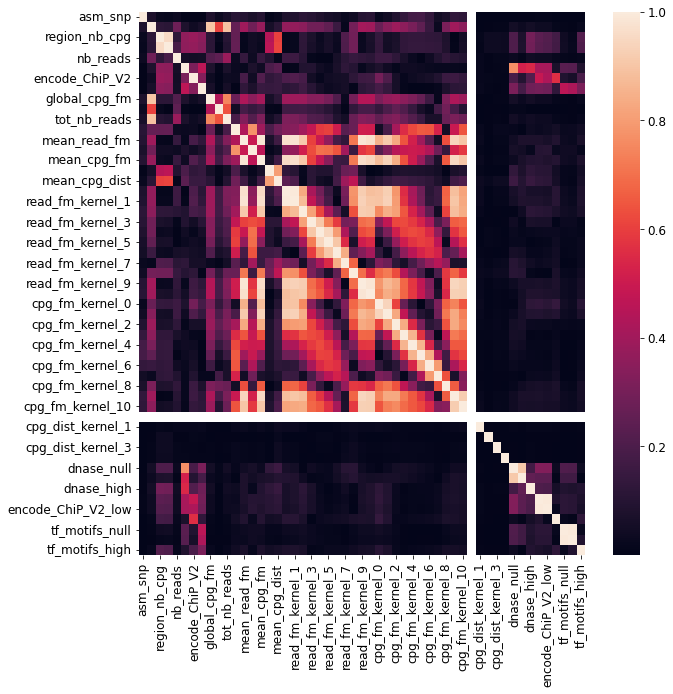

In [26]:
sns.heatmap(corr_matrix)

In [28]:
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = selected_features_df.columns[columns]
print(selected_columns)
selected_features_df = selected_features_df[selected_columns]

Index(['asm_snp', 'sample_category', 'region_nb_cpg', 'nb_reads', 'dnase',
       'encode_ChiP_V2', 'tf_motifs', 'tot_nb_cpg', 'tot_nb_reads',
       'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'std_cpg_dist',
       'mean_cpg_dist', 'read_fm_kernel_3', 'read_fm_kernel_7',
       'read_fm_kernel_8', 'cpg_fm_kernel_0', 'cpg_fm_kernel_2',
       'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5',
       'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8',
       'cpg_dist_kernel_0', 'cpg_dist_kernel_1', 'cpg_dist_kernel_2',
       'cpg_dist_kernel_3', 'cpg_dist_kernel_4', 'dnase_null', 'dnase_high',
       'encode_ChiP_V2_null', 'encode_ChiP_V2_high', 'tf_motifs_null',
       'tf_motifs_high'],
      dtype='object')


In [12]:

corr_matrix = pd.DataFrame(abs(selected_features_df.corr()['asm_snp'])).sort_values(by = 'asm_snp')
print(corr_matrix)
corr_matrix.to_csv('corr.csv', index = True)

                      asm_snp
cpg_dist_kernel_3    0.000925
tf_motifs_high       0.001005
encode_ChiP_V2_high  0.001021
tf_motifs_low        0.001123
tf_motifs_null       0.001241
cpg_dist_kernel_4    0.002143
dnase_null           0.002486
cpg_dist_kernel_2    0.002750
cpg_dist_kernel_1    0.002904
dnase                0.004391
tf_motifs            0.005108
dnase_low            0.005543
encode_ChiP_V2       0.007121
dnase_high           0.007337
encode_ChiP_V2_null  0.009591
encode_ChiP_V2_low   0.009732
std_cpg_dist         0.010375
nb_cpg_found         0.022212
cpg_fm_kernel_0      0.023218
region_nb_cpg        0.023822
read_fm_kernel_7     0.025201
mean_cpg_dist        0.027319
tot_nb_cpg           0.033269
nb_reads             0.035047
cpg_fm_kernel_1      0.044876
read_fm_kernel_8     0.045463
cpg_fm_kernel_7      0.047487
read_fm_kernel_6     0.052340
read_fm_kernel_5     0.064641
tot_nb_reads         0.065546
std_cpg_fm           0.072728
cpg_fm_kernel_8      0.074199
sample_cat

### Remove variables with no correlation

In [13]:
vars_no_corr = list(corr_matrix[pd.isna(corr_matrix['asm_snp']) == True].index)
print(vars_no_corr)
selected_features_df = selected_features_df.drop(vars_no_corr, axis = 1)

['cpg_dist_kernel_0']


### Remove variables that are poorly correlated with ASM

In [225]:
vars_low_corr = list(corr_matrix[corr_matrix['asm_snp'] < MIN_CORR].index)
print(vars_low_corr)
selected_features_df = selected_features_df.drop(vars_low_corr, axis =1)

['encode_ChiP_V2_high', 'cpg_dist_kernel_4', 'tf_motifs', 'encode_ChiP_V2', 'dnase_high', 'dnase', 'tf_motifs_null', 'cpg_dist_kernel_3', 'encode_ChiP_V2_null', 'cpg_dist_kernel_2', 'encode_ChiP_V2_low', 'tf_motifs_low', 'std_cpg_dist', 'tf_motifs_high', 'cpg_dist_kernel_1', 'dnase_null', 'dnase_low', 'tot_nb_cpg', 'nb_cpg_found', 'region_nb_cpg', 'cpg_fm_kernel_0', 'mean_cpg_dist', 'nb_reads', 'read_fm_kernel_7', 'cpg_fm_kernel_1', 'read_fm_kernel_8']


### Run two PCA for read FM variables and CpG FM variables

In [226]:
# We use a polynomial model and output 5 variables
kpca = KernelPCA(n_components = 3, kernel="poly") # linear, Cosine, poly, rbf

In [227]:
# Print the columns
selected_features_df.columns

Index(['asm_snp', 'sample_category', 'global_cpg_fm', 'tot_nb_reads',
       'std_read_fm', 'mean_read_fm', 'std_cpg_fm', 'mean_cpg_fm',
       'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2',
       'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5',
       'read_fm_kernel_6', 'read_fm_kernel_9', 'read_fm_kernel_10',
       'cpg_fm_kernel_2', 'cpg_fm_kernel_3', 'cpg_fm_kernel_4',
       'cpg_fm_kernel_5', 'cpg_fm_kernel_6', 'cpg_fm_kernel_7',
       'cpg_fm_kernel_8', 'cpg_fm_kernel_9', 'cpg_fm_kernel_10',
       'genomic_matrix'],
      dtype='object')

In [228]:
cpg_fm_vars = []
for var in selected_features_df.columns:
    if "cpg_fm" in var:
        cpg_fm_vars = cpg_fm_vars + [var]
print(cpg_fm_vars)

# Run the PCA
kpca_cpg_fm_features = kpca.fit_transform(selected_features_df[cpg_fm_vars])

['global_cpg_fm', 'std_cpg_fm', 'mean_cpg_fm', 'cpg_fm_kernel_2', 'cpg_fm_kernel_3', 'cpg_fm_kernel_4', 'cpg_fm_kernel_5', 'cpg_fm_kernel_6', 'cpg_fm_kernel_7', 'cpg_fm_kernel_8', 'cpg_fm_kernel_9', 'cpg_fm_kernel_10']


In [230]:
cpg_fm_df = pd.DataFrame(data = kpca_cpg_fm_features, 
             columns = ['pca_cpg_fm_1', 'pca_cpg_fm_2', 
                        'pca_cpg_fm_3'])

# Add the new PCA features
selected_features_df = pd.concat([selected_features_df,cpg_fm_df], axis = 1)

# Remove the columns used in the PCA
selected_features_df = selected_features_df.drop(cpg_fm_vars, axis = 1)

In [231]:
read_fm_vars = []
for var in selected_features_df.columns:
    if "read_fm" in var:
        read_fm_vars = read_fm_vars + [var]
print(read_fm_vars)

# Run the PCA
kpca_read_fm_features = kpca.fit_transform(selected_features_df[read_fm_vars])

['std_read_fm', 'mean_read_fm', 'read_fm_kernel_0', 'read_fm_kernel_1', 'read_fm_kernel_2', 'read_fm_kernel_3', 'read_fm_kernel_4', 'read_fm_kernel_5', 'read_fm_kernel_6', 'read_fm_kernel_9', 'read_fm_kernel_10']


In [232]:
read_fm_df = pd.DataFrame(data = kpca_cpg_fm_features, 
             columns = ['pca_read_fm_1', 'pca_read_fm_2', 
                        'pca_read_fm_3'])

# Add the new PCA features
selected_features_df = pd.concat([selected_features_df,read_fm_df], axis = 1)

# Remove the columns used in the PCA
selected_features_df = selected_features_df.drop(read_fm_vars, axis = 1)

In [233]:
selected_features_df.columns

Index(['asm_snp', 'sample_category', 'tot_nb_reads', 'genomic_matrix',
       'pca_cpg_fm_1', 'pca_cpg_fm_2', 'pca_cpg_fm_3', 'pca_read_fm_1',
       'pca_read_fm_2', 'pca_read_fm_3'],
      dtype='object')

In [ ]:
# Remove the features based on kernel
# non_kernel_features = [s for s in selected_features_df.columns if "kernel" not in s]
# non_kernel_features = [s for s in non_kernel_features if "sample_category" not in s]
# print(non_kernel_features)
# selected_features_df = selected_features_df[non_kernel_features]

In [234]:
backup = selected_features_df.copy()

In [235]:
#selected_features_df = selected_features_df.drop(['sample_category', 'tot_nb_reads'], axis = 1)

In [236]:
# Check the correlation of the features with ASM
corr_matrix = pd.DataFrame(abs(selected_features_df.corr()['asm_snp'])).sort_values(by = 'asm_snp')
print(corr_matrix)

                  asm_snp
pca_cpg_fm_2     0.005818
pca_read_fm_2    0.005818
tot_nb_reads     0.054280
sample_category  0.075737
pca_cpg_fm_3     0.111526
pca_read_fm_3    0.111526
pca_cpg_fm_1     0.136675
pca_read_fm_1    0.136675
asm_snp          1.000000


## Normalization

In [30]:
normalized_df = selected_features_df.copy()
normalized_df = normalized_df.drop(['asm_snp', 'sample_category'], axis = 1)
scaler = StandardScaler()
scaler.fit(normalized_df)
test = scaler.transform(normalized_df)

In [32]:
normalized_df = pd.DataFrame(test)
normalized_df = pd.concat([normalized_df, 
                           selected_features_df[['asm_snp', 'sample_category']]], axis = 1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
normalized_df

## Split the dataset for training and testing

We use the sklearn `train_test_split` function. The validation set will be carved out from the training set when training the model. The validation set will be  used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. 

In [240]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(normalized_df, test_size=TEST_SPLIT)

# Form np arrays of labels
train_labels = np.array(train_df.pop('asm_snp'))
test_labels = np.array(test_df.pop('asm_snp'))

# Np arrays of features for CNN/RNN
train_image_feature = np.array(train_df['genomic_matrix'].tolist())
test_image_feature = np.array(test_df['genomic_matrix'].tolist())

# Remove the matrix for the datasets
train_df.drop('genomic_matrix', axis = 1, inplace = True)
test_df.drop('genomic_matrix', axis = 1, inplace = True)

# np arrays for  linear/perceptron
train_scalar_features = np.array(train_df)
test_scalar_features = np.array(test_df)

# Check size of arrays for CNN (X,250,3)
display("Image features")
display("Size of the TRAIN dataset for images:", train_image_feature.shape)
display("Size of the TEST dataset for images:", test_image_feature.shape)

# # Check size of arrays for scalar features (X, 39)
display("SCALAR FEATURES:")
display("Size of the TRAIN datase:", train_scalar_features.shape)
display("Size of the TEST dataset:", test_scalar_features.shape)

# # Check size of arrays for the labels
display("LABELS:")
display("Size of the TRAIN LABELS dataset:", train_labels.shape)
display("Size of the TEST LABELS dataset:", test_labels.shape)

'Image features'

'Size of the TRAIN dataset for images:'

(40000, 1000, 2)

'Size of the TEST dataset for images:'

(10000, 1000, 2)

'SCALAR FEATURES:'

'Size of the TRAIN datase:'

(40000, 8)

'Size of the TEST dataset:'

(10000, 8)

'LABELS:'

'Size of the TRAIN LABELS dataset:'

(40000,)

'Size of the TEST LABELS dataset:'

(10000,)

## Logistic regression

In [140]:
def make_logistic_regression_model(output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential()
    
    # Normalize the features
    # model.add(
    #     layers.BatchNormalization(
    #         axis=-1,
    #         momentum = 0.99,
    #         epsilon = 0.001,
    #         input_dim = train_scalar_features.shape[1])
    # )
    model.add(
        layers.Normalization(
            axis = 1,
            input_dim = train_scalar_features.shape[1])
    )
    
    # Linear model
    model.add(
        layers.Dense(
                1,  # number of classes
                activation='sigmoid', #'sigmoid' 'softmax'
                kernel_regularizer = keras.regularizers.L1L2(
                    l1 = L1_R, 
                    l2 = L2_R),
                bias_initializer=output_bias
                )
    )
 
  
    model.compile(
        optimizer = 'sgd' , # sgd = stochastic gradient descent, rmsprop
        loss= 'binary_crossentropy', # 'mse' 'categorical_crossentropy', 'binary_crossentropy'
        metrics = METRICS)

    return model


In [219]:
normalizer = layers.Normalization()
normalizer.adapt(train_scalar_features)

In [181]:
selected_features_df.describe()

,asm_snp,pca_cpg_fm_1,pca_cpg_fm_2,pca_cpg_fm_3,pca_cpg_fm_4,pca_cpg_fm_5,pca_read_fm_1,pca_read_fm_2,pca_read_fm_3,pca_read_fm_4,pca_read_fm_5
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04
mean,0.014260,2.402878e-16,4.306192e-16,-7.468870e-16,2.706119e-16,1.747935e-16,2.402878e-16,4.306192e-16,-7.468870e-16,2.706119e-16,1.747935e-16
std,0.118562,2.208884e+00,9.007871e-01,4.905100e-01,4.041753e-01,3.076128e-01,2.208884e+00,9.007871e-01,4.905100e-01,4.041753e-01,3.076128e-01
min,0.000000,-3.062736e+00,-1.549168e+00,-1.562781e+00,-1.420869e+00,-1.314317e+00,-3.062736e+00,-1.549168e+00,-1.562781e+00,-1.420869e+00,-1.314317e+00
25%,0.000000,-2.232006e+00,-7.486027e-01,-3.279233e-01,-2.303849e-01,-1.572722e-01,-2.232006e+00,-7.486027e-01,-3.279233e-01,-2.303849e-01,-1.572722e-01
50%,0.000000,-5.206468e-01,-2.096190e-01,1.048871e-02,-3.865631e-02,7.664590e-02,-5.206468e-01,-2.096190e-01,1.048871e-02,-3.865631e-02,7.664590e-02
75%,0.000000,2.506118e+00,5.712621e-01,2.793249e-01,1.702202e-01,1.517640e-01,2.506118e+00,5.712621e-01,2.793249e-01,1.702202e-01,1.517640e-01
max,1.000000,3.594936e+00,4.172272e+00,3.125927e+00,3.740141e+00,2.670186e+00,3.594936e+00,4.172272e+00,3.125927e+00,3.740141e+00,2.670186e+00


In [201]:
# Create a Normalization layer and set its internal state using the training data
#normalizer = layers.Normalization()
#normalizer.adapt(train_scalar_features)

input_shape = train_scalar_features.shape[1:]
print(input_shape)
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
outputs = layers.Dense(1, activation="sigmoid")(x)
linear_model = keras.Model(inputs, outputs)


(10,)


In [202]:
linear_model.compile(
        optimizer = 'sgd' , # sgd = stochastic gradient descent, rmsprop
        loss= 'binary_crossentropy', # 'mse' 'categorical_crossentropy', 'binary_crossentropy'
        metrics = METRICS)

In [241]:
linear_model = make_logistic_regression_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 26
Trainable params: 9
Non-trainable params: 17
_________________________________________________________________


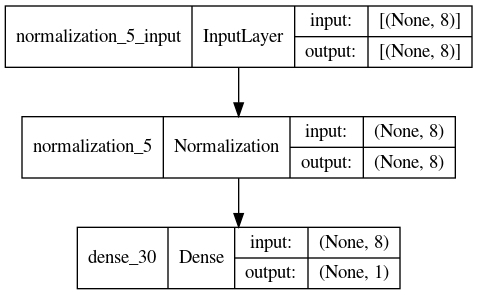

In [242]:
linear_model.summary()
keras.utils.plot_model(linear_model, "linear_model.png", show_shapes=True)

In [243]:
linear_training = linear_model.fit(
    train_scalar_features,
    train_labels,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [EARLY_STOPPING],
    validation_split = VALIDATION_SPLIT,
    class_weight = class_weight_asm) 

Epoch 1/100
28/28 [==============================] - 2s 31ms/step - loss: 1.0380 - tp: 525.0000 - fp: 28688.0000 - tn: 8775.0000 - fn: 12.0000 - accuracy: 0.2447 - precision: 0.0180 - sensitivity: 0.9777 - auc: 0.7137 - val_loss: 1.9210 - val_tp: 182.0000 - val_fp: 10889.0000 - val_tn: 929.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0926 - val_precision: 0.0164 - val_sensitivity: 1.0000 - val_auc: 0.7326
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.9890 - tp: 399.0000 - fp: 25251.0000 - tn: 2350.0000 - fn: 0.0000e+00 - accuracy: 0.0982 - precision: 0.0156 - sensitivity: 1.0000 - auc: 0.7305 - val_loss: 1.8178 - val_tp: 182.0000 - val_fp: 10744.0000 - val_tn: 1074.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.1047 - val_precision: 0.0167 - val_sensitivity: 1.0000 - val_auc: 0.7394
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.9434 - tp: 399.0000 - fp: 24862.0000 - tn: 2739.0000 - fn: 0.0000e+00 - accuracy: 0.1121 - precision: 0.01

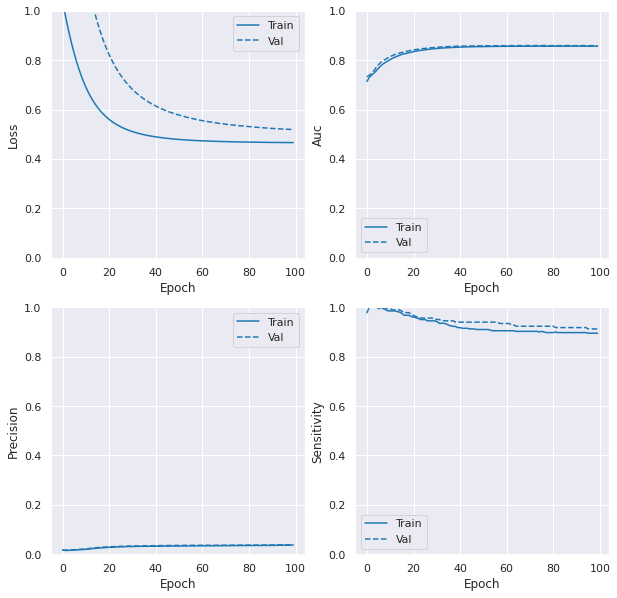

In [244]:
plot_metrics(linear_training)

In [245]:
# Evaluate model on the test dataset
linear_results = linear_model.evaluate(test_scalar_features, test_labels, batch_size= BATCH_SIZE,
                                           verbose=1)

display_results(linear_results)

10/10 [==============================] - 0s 4ms/step - loss: 0.5153 - tp: 121.0000 - fp: 3332.0000 - tn: 6536.0000 - fn: 11.0000 - accuracy: 0.6657 - precision: 0.0350 - sensitivity: 0.9167 - auc: 0.8682
Loss 0.515
True positives 121.0
False positives 3332.0
True negatives 6536.0
False negatives 11.0
Accuracy 0.666
Precision 0.035
Sensitivity 0.917
AUC 0.868


## Perceptron model

In [246]:
def make_perceptron_model(output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
  
    model = keras.Sequential()
  
#     # Normalize the features
#     model.add(
#         layers.Normalization(
#             axis = 1,
#             input_dim = train_scalar_features.shape[-1])
#     )
        
  # Initial perceptron layer
    model.add(
        layers.Dense(
            NB_NODES_PERCEPTRON, 
            activation=ACTIVATION_FUNCTION,
            input_dim = train_scalar_features.shape[-1],
            kernel_regularizer = keras.regularizers.L1L2(
                    l1 = L1_R, 
                    l2 = L2_R)
        )
    )
  
    # Range of neuron layers
    for layer_number in range(0, NB_LAYERS_PERCEPTRON-1): 
        model.add(layers.Dense(
            NB_NODES_PERCEPTRON, 
            activation = ACTIVATION_FUNCTION,
            kernel_regularizer = keras.regularizers.L1L2(
                    l1 = L1_R, 
                    l2 = L2_R)))
  
    # Dropout layer
    model.add(layers.Dropout(0.5))

    # We add a sigmoid to create the probability function of the ASM event.
    model.add(
        layers.Dense(
            1, 
            activation='sigmoid',
            bias_initializer=output_bias,
            kernel_regularizer = keras.regularizers.L1L2(
                    l1 = L1_R, 
                    l2 = L2_R)))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        loss = keras.losses.BinaryCrossentropy(),
        metrics = METRICS)

    return model


In [247]:
perceptron_model = make_perceptron_model()
perceptron_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 10)                90        
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 dense_33 (Dense)            (None, 10)                110       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 10)                110       
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                

In [248]:
perceptron_training = perceptron_model.fit(
    train_scalar_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [EARLY_STOPPING],
    validation_split = VALIDATION_SPLIT,
    class_weight=class_weight_asm) 

Epoch 1/100
28/28 [==============================] - 2s 33ms/step - loss: 0.9727 - tp: 121.0000 - fp: 3332.0000 - tn: 34137.0000 - fn: 410.0000 - accuracy: 0.9015 - precision: 0.0350 - sensitivity: 0.2279 - auc: 0.6143 - val_loss: 0.3106 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 11818.0000 - val_fn: 182.0000 - val_accuracy: 0.9848 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_auc: 0.5104
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.9281 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27601.0000 - fn: 399.0000 - accuracy: 0.9858 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - auc: 0.5089 - val_loss: 0.3310 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 11818.0000 - val_fn: 182.0000 - val_accuracy: 0.9848 - val_precision: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_auc: 0.5511
Epoch 3/100
28/28 [==============================] - 0s 7ms/step - loss: 0.8980 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27601.0000 - fn: 399.0000 - accu

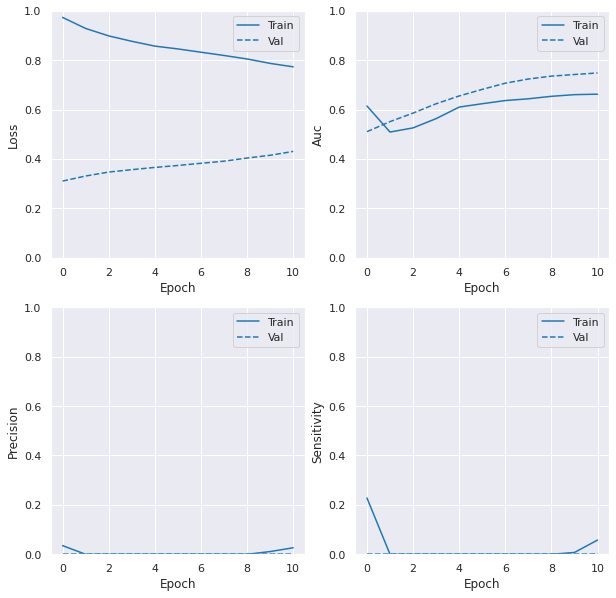

In [249]:
plot_metrics(perceptron_training)

In [220]:
perceptron_results = perceptron_model.evaluate(test_scalar_features, 
                                               test_labels, 
                                               batch_size= BATCH_SIZE,
                                               verbose=1)
display_results(perceptron_results)

10/10 [==============================] - 0s 4ms/step - loss: 0.5361 - tp: 126.0000 - fp: 3100.0000 - tn: 6762.0000 - fn: 12.0000 - accuracy: 0.6888 - precision: 0.0391 - sensitivity: 0.9130 - auc: 0.8721
Loss 0.536
True positives 126.0
False positives 3100.0
True negatives 6762.0
False negatives 12.0
Accuracy 0.689
Precision 0.039
Sensitivity 0.913
AUC 0.872


## CNN model with the genomic picture as sole input

In [257]:
def make_simple_cnn_model(output_bias = None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Start the model
    model = keras.Sequential()
    
    # Normalize the features
    model.add(
        layers.BatchNormalization(
            axis=-1,
            momentum = 0.99,
            epsilon = 0.001,
            input_shape=(train_image_feature.shape[1], train_image_feature.shape[2])
        )
    )  
    
    # Add a convolutional layer
    model.add(layers.Conv1D(
        filters = CNN_FILTERS, 
        kernel_size = CNN_KERNEL,
        activation = ACTIVATION_FUNCTION,
        kernel_regularizer = keras.regularizers.L1L2(
                            l1 = L1_R, 
                            l2 = L2_R)))

    # Pooling
    model.add(layers.MaxPooling1D(pool_size=2))
  
    # Flattening
    model.add(layers.Flatten())
  
    # Output layer (Sigmoid)
    model.add(layers.Dense(1, activation='sigmoid', 
                         kernel_regularizer = keras.regularizers.L1L2(
                            l1 = L1_R, 
                            l2 = L2_R),
                         bias_initializer=output_bias))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        loss = 'binary_crossentropy',
        metrics = METRICS)

    return model

In [258]:
simple_cnn_model = make_simple_cnn_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 1000, 2)          8         
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 32)           48032     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4000)              0         
                                                                 
 dense_38 (Dense)            (None, 1)                 4001      
                                                                 
Total params: 52,041
Trainable params: 52,037
Non-trai

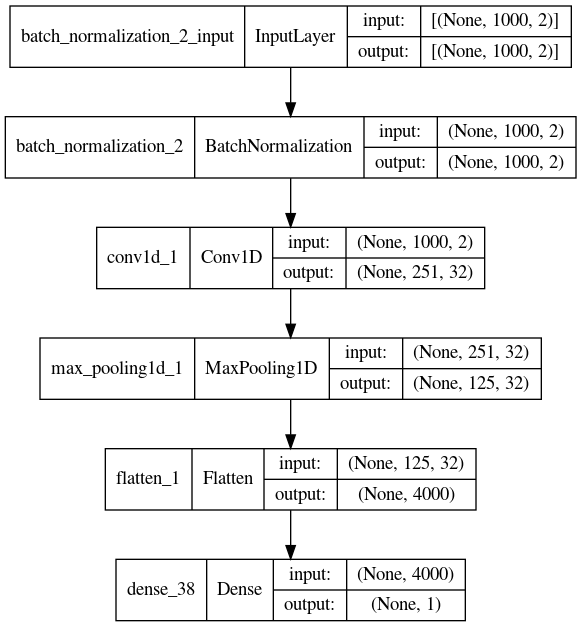

In [259]:
simple_cnn_model.summary()
keras.utils.plot_model(simple_cnn_model, "cnn_model.png", show_shapes=True)

In [260]:
simple_cnn_training = simple_cnn_model.fit(
    train_image_feature,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [EARLY_STOPPING],
    validation_split = VALIDATION_SPLIT,
    class_weight=class_weight_asm) 

Epoch 1/100
28/28 [==============================] - 3s 57ms/step - loss: 0.6987 - tp: 184.0000 - fp: 11408.0000 - tn: 26061.0000 - fn: 347.0000 - accuracy: 0.6907 - precision: 0.0159 - sensitivity: 0.3465 - auc: 0.5446 - val_loss: 0.7937 - val_tp: 181.0000 - val_fp: 11734.0000 - val_tn: 84.0000 - val_fn: 1.0000 - val_accuracy: 0.0221 - val_precision: 0.0152 - val_sensitivity: 0.9945 - val_auc: 0.5964
Epoch 2/100
28/28 [==============================] - 1s 27ms/step - loss: 0.5298 - tp: 346.0000 - fp: 7081.0000 - tn: 20520.0000 - fn: 53.0000 - accuracy: 0.7452 - precision: 0.0466 - sensitivity: 0.8672 - auc: 0.8927 - val_loss: 0.7550 - val_tp: 171.0000 - val_fp: 9935.0000 - val_tn: 1883.0000 - val_fn: 11.0000 - val_accuracy: 0.1712 - val_precision: 0.0169 - val_sensitivity: 0.9396 - val_auc: 0.6382
Epoch 3/100
28/28 [==============================] - 1s 27ms/step - loss: 0.4500 - tp: 376.0000 - fp: 5557.0000 - tn: 22044.0000 - fn: 23.0000 - accuracy: 0.8007 - precision: 0.0634 - sensit

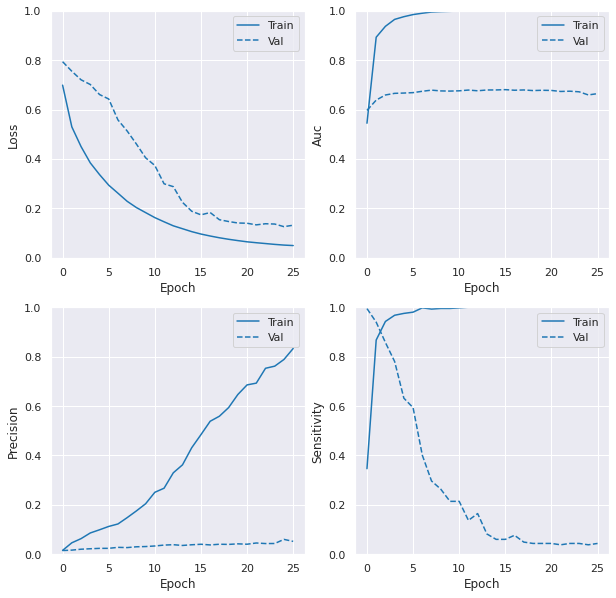

In [261]:
plot_metrics(simple_cnn_training)

In [262]:
# Evaluate model on the test dataset
simple_cnn_results = simple_cnn_model.evaluate(
    test_image_feature, 
    test_labels, 
    batch_size = BATCH_SIZE,
    verbose=1)

display_results(simple_cnn_results)

10/10 [==============================] - 0s 8ms/step - loss: 0.1638 - tp: 4.0000 - fp: 191.0000 - tn: 9677.0000 - fn: 128.0000 - accuracy: 0.9681 - precision: 0.0205 - sensitivity: 0.0303 - auc: 0.7104   
Loss 0.164
True positives 4.0
False positives 191.0
True negatives 9677.0
False negatives 128.0
Accuracy 0.968
Precision 0.021
Sensitivity 0.03
AUC 0.71


## Recurrent Neural Network

In [149]:
def make_simple_rnn_model():

    nb_dim_in_genomic_seq = train_image_feature.shape[2] # Should be 3

    model = keras.models.Sequential()
    
    # Normalize the features
    model.add(
        layers.BatchNormalization(
            axis=-1,
            momentum = 0.99,
            epsilon = 0.001,
            input_shape=(train_image_feature.shape[1], train_image_feature.shape[2])
        )
    )  
    
    model.add(layers.LSTM(RNN_UNITS, input_shape=(None, nb_dim_in_genomic_seq), go_backwards = False))

    # Output layer (Sigmoid)
    model.add(layers.Dense(1, activation='sigmoid', 
                         kernel_regularizer = keras.regularizers.L1L2(
                            l1 = L1_R, 
                            l2 = L2_R)
                         ))

    model.compile(
      optimizer = keras.optimizers.Adam(learning_rate =LEARNING_RATE),
      loss = 'binary_crossentropy',
      metrics = METRICS)
    
    return model

In [150]:
simple_rnn_model = make_simple_rnn_model()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 1000, 3)          12        
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,725
Trainable params: 67,719
Non-trainable params: 6
_________________________________________________________________


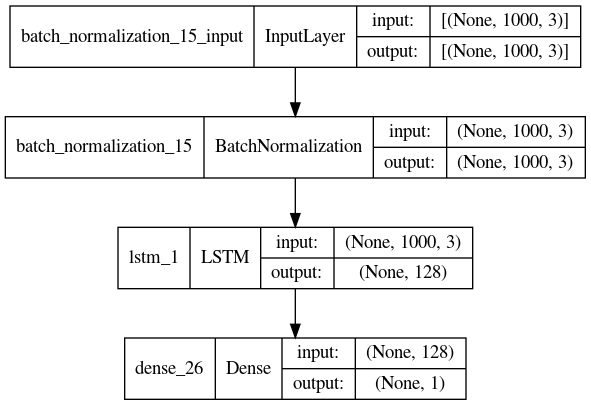

In [151]:
simple_rnn_model.summary()
keras.utils.plot_model(simple_rnn_model, "cnn_model.png", show_shapes=True)

In [152]:
simple_rnn_training = simple_rnn_model.fit(
    train_image_feature,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [EARLY_STOPPING],
    validation_split = VALIDATION_SPLIT,
    class_weight=class_weight_asm) 

Epoch 1/100
221/221 [==============================] - 23s 95ms/step - loss: 0.6570 - tp: 3150.0000 - fp: 154651.0000 - tn: 140840.0000 - fn: 1095.0000 - accuracy: 0.4804 - precision: 0.0200 - sensitivity: 0.7420 - auc: 0.6516 - val_loss: 0.7773 - val_tp: 1415.0000 - val_fp: 93239.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0149 - val_precision: 0.0149 - val_sensitivity: 1.0000 - val_auc: 0.5178
Epoch 2/100
221/221 [==============================] - 19s 84ms/step - loss: 0.6796 - tp: 1928.0000 - fp: 121485.0000 - tn: 96274.0000 - fn: 1171.0000 - accuracy: 0.4446 - precision: 0.0156 - sensitivity: 0.6221 - auc: 0.5691 - val_loss: 0.7673 - val_tp: 947.0000 - val_fp: 60378.0000 - val_tn: 32861.0000 - val_fn: 468.0000 - val_accuracy: 0.3572 - val_precision: 0.0154 - val_sensitivity: 0.6693 - val_auc: 0.5429
Epoch 3/100
221/221 [==============================] - 19s 84ms/step - loss: 0.6668 - tp: 2227.0000 - fp: 116114.0000 - tn: 101645.0000 - fn: 872.0000 - accuracy: 0

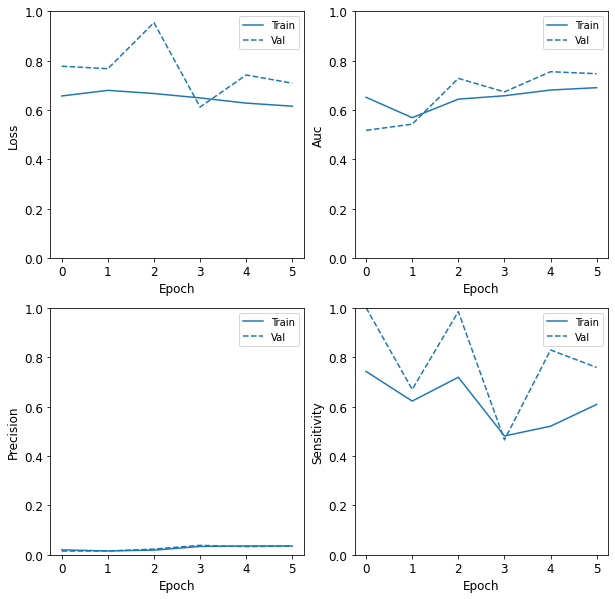

In [153]:
plot_metrics(simple_rnn_training)

In [154]:
# Evaluate model on the test dataset
simple_rnn_results = simple_rnn_model.evaluate(
    test_image_feature, 
    test_labels, 
    batch_size = BATCH_SIZE,
    verbose=1)

display_results(simple_rnn_results)

79/79 [==============================] - 2s 26ms/step - loss: 0.7773 - tp: 1146.0000 - fp: 77732.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0145 - precision: 0.0145 - sensitivity: 1.0000 - auc: 0.5165
Loss 0.777
True positives 1146.0
False positives 77732.0
True negatives 0.0
False negatives 0.0
Accuracy 0.015
Precision 0.015
Sensitivity 1.0
AUC 0.517
